In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

/tmp/ipykernel_1484/83197244.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

backend used:  ibmq_belem


In [3]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [4]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [5]:
n = 2

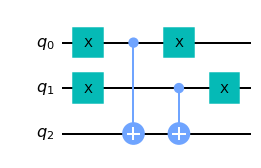

In [8]:
oracle_qc = dj_oracle('balanced', n)
oracle_qc.draw()

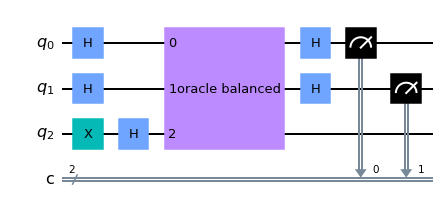

In [9]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

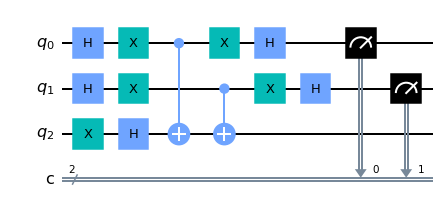

In [10]:
new_dj = dj_circuit.decompose('oracle balanced')

new_dj.draw()

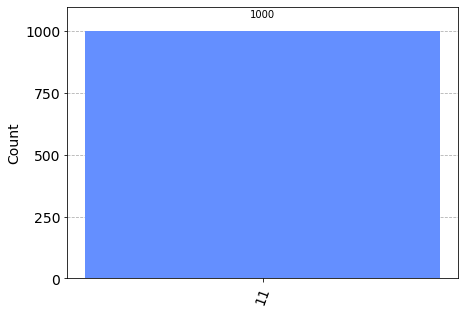

In [11]:
aer_backend = Aer.get_backend('aer_simulator')
aer_job = execute(dj_circuit, aer_backend, shots=1000)
aer_results = aer_job.result()
aer_counts = aer_results.get_counts()
plot_histogram(aer_counts)

In [12]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

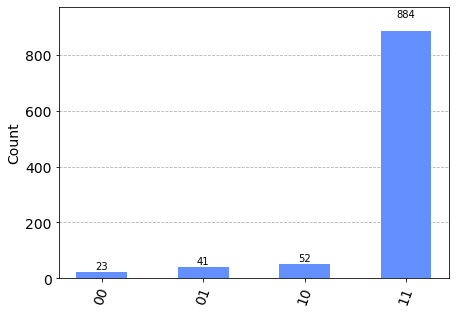

In [13]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [14]:
# QEM
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

In [15]:
meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [16]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(realqc_results)
mitigated_counts = mitigated_results.get_counts()

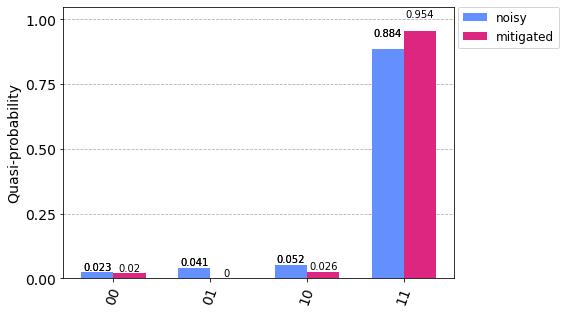

In [17]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [18]:
# GEM

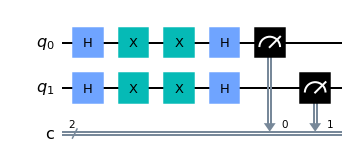

In [19]:
# not calibrating ancilla
# depends on the concrete DJ circuit: x on 0,1
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)

dj_left0.h(0)

dj_left0.h(1)
dj_left0.x(0)
dj_left0.x(1)
dj_left0.x(0)
dj_left0.x(1)


dj_left0.h(0)
dj_left0.h(1)
dj_left0.measure([0,1], [0,1])
dj_left0.draw()

/tmp/ipykernel_1484/4132221646.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left1 += dj_left0


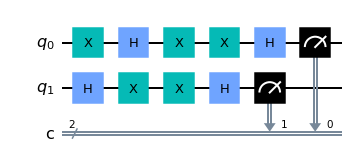

In [20]:
dj_left1 = QuantumCircuit(n, n)
dj_left1.x(0)
dj_left1 += dj_left0

dj_left1.draw()

/tmp/ipykernel_1484/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


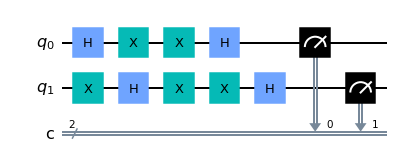

In [21]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_1484/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


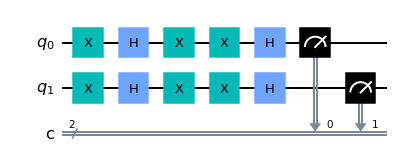

In [22]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

In [23]:
meas_calibs1 = [dj_left0, dj_left1, dj_left2, dj_left3]

In [24]:
# for circuit in meas_calibs1:
#     print('Circuit',circuit.name)
#     print(circuit)

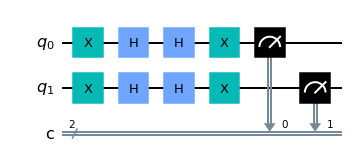

In [25]:
# not calibrating ancilla
dj_right0 = QuantumCircuit(n,n)
dj_right1 = QuantumCircuit(n) 
dj_right2 = QuantumCircuit(n)
dj_right3 = QuantumCircuit(n)

dj_right0.x(0)
dj_right0.x(1)
dj_right0.h(0)
dj_right0.h(1)
dj_right0.h(0)
dj_right0.h(1)
dj_right0.x(1)
dj_right0.x(0)

dj_right0.measure([0,1], [0,1])
dj_right0.draw()

/tmp/ipykernel_1484/4058473414.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right1 += dj_right0


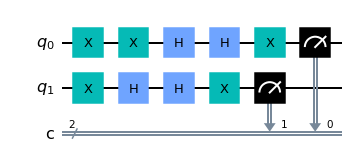

In [26]:
dj_right1 = QuantumCircuit(n, n)
dj_right1.x(0)
dj_right1 += dj_right0

dj_right1.draw()

/tmp/ipykernel_1484/1107241932.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right2 += dj_right0


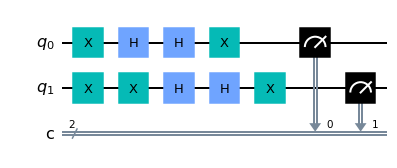

In [27]:
dj_right2.x(1)
dj_right2 += dj_right0
dj_right2.draw()

/tmp/ipykernel_1484/2247627861.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right3 += dj_right0


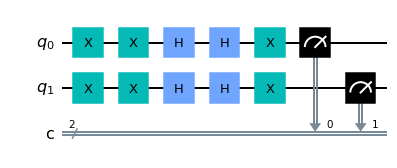

In [28]:
dj_right3.x(0)
dj_right3.x(1)
dj_right3 += dj_right0
dj_right3.draw()

In [29]:
meas_calibs2 = [dj_right0, dj_right1, dj_right2, dj_right3]

In [ ]:
# for circuit in meas_calibs2:
#     print('Circuit',circuit.name)
#     print(circuit)

In [ ]:
# aer_sim = Aer.get_backend("aer_simulator")
# cal_results = aer_sim.run(meas_calibs1, shots=10000).result()

In [ ]:
# plot_histogram(cal_results.get_counts())

In [30]:
t_qc = transpile(meas_calibs1, real_backend)
qobj = assemble(t_qc, shots=10000)
results_left = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_1484/1392241283.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  results_left = real_backend.run(qobj, shots=10000).result()


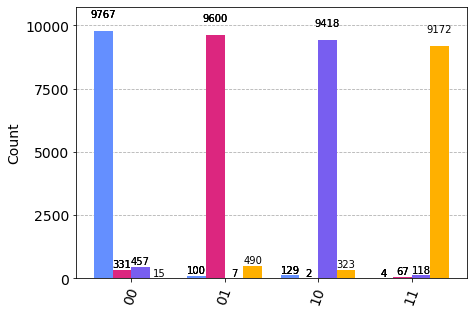

In [31]:
result_counts_left = results_left.get_counts()
plot_histogram(result_counts_left)

In [32]:
ls = []
for qc in meas_calibs1:
     counts = results_left.get_counts(qc)
     this_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
array = np.array(ls)

array_t_left = np.transpose(array)
print(array_t_left)

[9.767e-01 1.000e-02 1.290e-02 4.000e-04]
[3.31e-02 9.60e-01 2.00e-04 6.70e-03]
[4.570e-02 7.000e-04 9.418e-01 1.180e-02]
[0.0015 0.049  0.0323 0.9172]
[[9.767e-01 3.310e-02 4.570e-02 1.500e-03]
 [1.000e-02 9.600e-01 7.000e-04 4.900e-02]
 [1.290e-02 2.000e-04 9.418e-01 3.230e-02]
 [4.000e-04 6.700e-03 1.180e-02 9.172e-01]]


In [33]:
array_to_latex(array_t_left)

<IPython.core.display.Latex object>

In [34]:
t_qc = transpile(meas_calibs2, real_backend)
qobj = assemble(t_qc, shots=10000)
results_right = real_backend.run(qobj, shots=10000).result()

In [35]:
result_counts_right = results_right.get_counts()
print(result_counts_right)

[{'00': 9752, '01': 100, '10': 145, '11': 3}, {'00': 311, '01': 9614, '10': 4, '11': 71}, {'00': 484, '01': 7, '10': 9415, '11': 94}, {'00': 13, '01': 466, '10': 271, '11': 9250}]


In [36]:
ls = []
for qc in meas_calibs2:
     counts = results_right.get_counts(qc)
     this_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     # print(this_array)
array = np.array(ls)

array_t_right = np.transpose(array)
print(array_t_right)

[[9.752e-01 3.110e-02 4.840e-02 1.300e-03]
 [1.000e-02 9.614e-01 7.000e-04 4.660e-02]
 [1.450e-02 4.000e-04 9.415e-01 2.710e-02]
 [3.000e-04 7.100e-03 9.400e-03 9.250e-01]]


In [37]:
array_to_latex(array_t_right)

<IPython.core.display.Latex object>

In [38]:
array_sum = (array_t_left + array_t_right) / 2
array_to_latex(array_sum)

<IPython.core.display.Latex object>

In [39]:
import scipy.linalg as la
array_inv = la.inv(array_sum)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [40]:
counts = realqc_results.get_counts()

In [41]:
result_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
result_array = result_array/1000

In [42]:
result_array

array([0.023, 0.041, 0.052, 0.884])

In [43]:
mitigated = np.dot(array_inv, result_array)

In [44]:
array_to_latex(mitigated)

<IPython.core.display.Latex object>

In [45]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [46]:
array_to_latex(normal)

array([0.02744299, 0.        , 0.03104754, 1.        ])

In [47]:
def Normalize(arr):
    return arr/sum(arr)

In [48]:
new_normal = Normalize(mitigated)

In [49]:
array_to_latex(new_normal)

<IPython.core.display.Latex object>